<a href="https://colab.research.google.com/github/iciromaco/Semi3A/blob/master/NintendoARCards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nintendo の ARCardの画像データの生成

任天堂の公開されているARカードのデータを実験用に画像データ化するプログラム

# pdf2image と poppler のインストール

In [1]:
!pip install pdf2image
!apt install poppler-utils poppler-data

Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-data is already the newest version (0.4.8-2).
poppler-utils is already the newest version (0.62.0-2ubuntu2.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


In [0]:
import os
from pdf2image import convert_from_path
import numpy as np
import urllib.request
import cv2
from google.colab.patches import cv2_imshow
fname = "arcard"
pdfname = fname+".pdf"
url = 'https://www.nintendo.co.jp/support/3ds/pdf/3ds_arcard.pdf?_ga=2.223029147.1069627371.1591664344-847263550.1591664344'
urllib.request.urlretrieve(url, pdfname)

DPI = 50

images = convert_from_path(pdfname,dpi=DPI)
images[0].save(fname+".png", "png")
# images[0] 画像の確認がしたければ、コメントを外す

# ２階調化

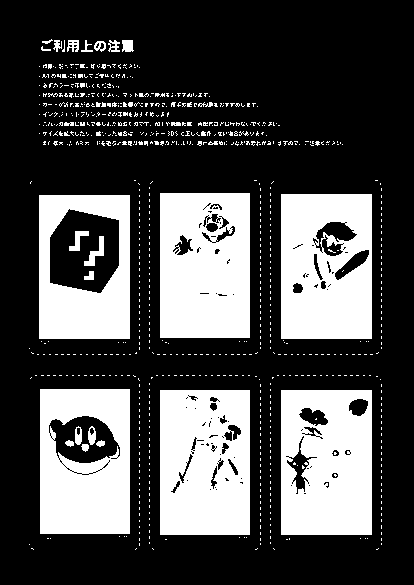

In [3]:
img = np.array(images[0])[:,:,::-1]# OpenCV 形式に変換
gry = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret,bw = cv2.threshold(gry,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
cv2_imshow(bw)

# 収縮膨張でノイズ除去

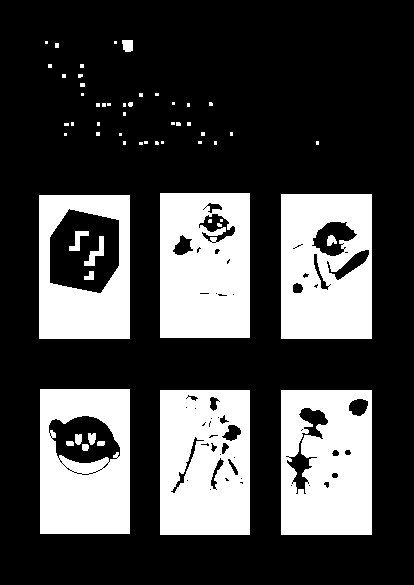

In [4]:
# noise removal
kernel = np.ones((3,3),np.uint8)
bw = cv2.morphologyEx(bw,cv2.MORPH_OPEN,kernel, iterations = 1)
cv2_imshow(bw)

In [0]:
# ラベリング処理
nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(bw)

- nlables はラベル数＝領域数（背景分の１を含む）  
- labels は　各画素の画素値としてラベル番号が割り当てられた画像  
- stats は各ラベルの矩形領域の左上の座標と幅、高さ、面積のデータ　　　　
- centroids は各連結成分の重心位置

In [6]:
stats

array([[     0,      0,    414,    585, 173805],
       [    45,     41,      3,      3,      9],
       [   114,     41,      3,      3,      9],
       [   122,     40,     11,     12,    118],
       [    55,     43,      4,      5,     20],
       [    48,     64,      4,      4,     16],
       [    80,     64,      4,      4,     16],
       [    62,     74,      4,      4,     16],
       [    78,     74,      5,      4,     18],
       [    80,     83,      5,      4,     20],
       [    81,     93,      3,      3,      9],
       [   139,     93,      4,      4,     16],
       [   155,     93,      4,      3,     12],
       [    96,    103,      4,      4,     16],
       [   102,    103,      4,      4,     16],
       [   107,    103,      4,      3,     12],
       [   123,    103,      3,      4,     12],
       [   128,    102,      5,      5,     22],
       [   172,    102,      3,      3,      9],
       [   187,    103,      3,      4,     12],
       [   209,    1

In [7]:
areas = stats[:,4] # 面積のデータのみ抜き出す
areas

array([173805,      9,      9,    118,     20,     16,     16,     16,
           18,     20,      9,     16,     12,     16,     16,     12,
           12,     22,      9,     12,     15,     12,     15,     12,
           12,     12,     19,     16,      9,     16,      9,     16,
           12,     12,     12,     15,      9,     12,     12,     12,
           12,  12202,   8369,  11606,     15,      9,     17,    175,
           77,    231,     65,  10573,  12241,  11888,     78,     69,
           38,     38,     45], dtype=int32)

In [8]:
# 面積の大きい順にインデックスを並べる
sareas  = np.argsort(areas)[::-1]
sareas

array([ 0, 52, 41, 53, 43, 51, 42, 49, 47,  3, 54, 48, 55, 50, 58, 56, 57,
       17,  9,  4, 26,  8, 46, 31, 27, 14, 29, 13, 11,  7,  6,  5, 22, 20,
       44, 35, 23, 32, 40, 39, 38, 37, 34, 24, 12, 33, 15, 16, 19, 25, 21,
       30, 10, 28, 36, 18, 45,  2,  1])

In [0]:
# カードの白領域のインデックス
cardareas = sareas[1:7]

In [10]:
cardimgs = [None]*6
for i in range(6):
  x1,y1,w,h = stats[cardareas[i]][:4]
  cardimgs[i] = img[y1:y1+h,x1:x1+w,:]
  print(cardimgs[i].shape)

(145, 90, 3)
(145, 90, 3)
(145, 91, 3)
(145, 91, 3)
(145, 90, 3)
(144, 91, 3)


# 大きさを統一して出力

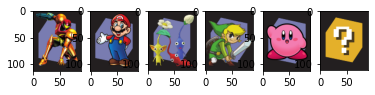

In [11]:
import matplotlib.pyplot as plt
h = int(cardimgs[0].shape[0]*0.783)
# Nintendo マークを特徴抽出対象から外すために、高さを 0.783 倍でカット
arcards = [None]*6
for i in range(6):
    arcards[i]=cardimgs[i][0:h,:,:]
    cv2.imwrite("ar"+str(i)+".png",arcards[i])
    plt.subplot(1,6,i+1)
    plt.imshow(arcards[i][:,:,::-1])